# Beer Topic Modeling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
import seaborn as sns
%matplotlib inline
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import re
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from pylab import *
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.externals import joblib
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

C:\Users\kylem\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
C:\Users\kylem\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
#import the beer data
beer_200_text = pd.read_csv(r'F:\Datasets\beer_200_text.csv')

#preview the dataset
beer_200_text.head()

,Unnamed: 0,beer_id,brewery_name,beer_name,lemmatized_text
0,0,5,Abita Brewing Co.,Amber,becoming favorite mine pours dark golden color...
1,1,6,Abita Brewing Co.,Turbodog,fan dark flavorful ale met mark well started c...
2,2,7,Abita Brewing Co.,Purple Haze,purple virtually head second finger head dissi...
3,3,10,Allagash Brewing Company,Dubbel Ale,brown ml bottle corked caged batch bottled acc...
4,4,17,Widmer Brothers Brewing Company,Widmer Hefeweizen,american style hefe taste delicious every time...


In [4]:
beer_200_text.shape

(1630, 5)

The objective here is to run the cleaned review text through an LDA algorithm to cluster the text review data. I'm assuming the topics will be mostly separated by flavor descriptors such as "citrusy", "hoppy", or "roasty" so I'm guessing LDA shouldn't have too hard of a time separating the text. For this exercise, I plan on utilizing Gensim's library.

## Gensim

In [3]:
#preprocess the data
from gensim.parsing.preprocessing import preprocess_string
us_reviews = beer_200_text.lemmatized_text.apply(preprocess_string).tolist()

In [4]:
#define variables
from gensim import corpora
from gensim.models.ldamodel import LdaModel

dictionary = corpora.Dictionary(us_reviews) 
corpus = [dictionary.doc2bow(lemmatized_text) for lemmatized_text in us_reviews]

In [7]:
#fit the model
NUM_TOPICS = 20
ldamodel = LdaModel(corpus, 
                    num_topics = NUM_TOPICS, 
                    id2word=dictionary, passes=10,
                    random_state=13) 

In [12]:
from sklearn.externals import joblib

joblib.dump(ldamodel, 'ldamodel20.pkl')

['ldamodel20.pkl']

In [16]:
#print the topics, five words per topic
ldamodel.print_topics(num_words=5)

[(0,
  '0.020*"sour" + 0.017*"tart" + 0.014*"cherri" + 0.013*"head" + 0.013*"like"'),
 (1,
  '0.018*"spice" + 0.016*"head" + 0.016*"pumpkin" + 0.016*"tast" + 0.013*"flavor"'),
 (2,
  '0.018*"vanilla" + 0.018*"sweet" + 0.015*"tast" + 0.014*"head" + 0.013*"flavor"'),
 (3,
  '0.041*"hop" + 0.020*"malt" + 0.018*"head" + 0.018*"nice" + 0.015*"tast"'),
 (4,
  '0.026*"hop" + 0.019*"ipa" + 0.017*"bitter" + 0.016*"citru" + 0.014*"head"'),
 (5,
  '0.009*"head" + 0.008*"hop" + 0.008*"tast" + 0.006*"flavor" + 0.006*"sweet"'),
 (6,
  '0.022*"sweet" + 0.018*"malt" + 0.015*"alcohol" + 0.015*"hop" + 0.015*"head"'),
 (7,
  '0.021*"brown" + 0.019*"dark" + 0.018*"sweet" + 0.017*"head" + 0.015*"alcohol"'),
 (8,
  '0.024*"light" + 0.022*"tast" + 0.016*"head" + 0.015*"like" + 0.013*"smell"'),
 (9,
  '0.018*"honei" + 0.018*"like" + 0.016*"sweet" + 0.014*"tast" + 0.014*"head"'),
 (10,
  '0.012*"hop" + 0.012*"tast" + 0.010*"malt" + 0.010*"like" + 0.009*"flavor"'),
 (11,
  '0.028*"chocol" + 0.025*"coffe" + 0.02

We can see some clear, separated topics, as per below:

- 0: Sour, tart and cherri - this describes the sour ale group.
- 1: Fall and/or pumpkin beers, could be seasonals in general.
- 2: The only term here that stands out is Vanilla. Vanilla is rather common in the beer industry so it's tough to distinguish here.
- 4: Bitter beers like IPA's, juicier hops
- 7: This could be any of the brown or amber ales. The darker malts lend more sweetness to beers.
- 11: Stouts, porters, dark ales
- 13: Wheat beers, very popular style throughout the world
- 15: This one is unique, obviously it's a flavored topic but it's very pepper heavy, even with habanero as one of the words.
- 16: Lime and salt tell me this could be a Mexican Lager category or some other light, tropical vibes style
- 17: Smoke and porter make me think this is another dark ale topic.
- 18: Barrel aged ales - bourbon, oak and vanilla are common descriptors of barrel aged beers, which sit in used bourbon barrels for months, or even years at a time.

Let's check out the coherence scores to see if we can determine an optimal number of topics for the model.

In [7]:
#define a function to calculate coherence scores of the ldamodel
from gensim.models.coherencemodel import CoherenceModel
def calculate_coherence_score(documents, dictionary, model):
    coherence_model = CoherenceModel(model=model, 
                                     texts=documents, 
                                     dictionary=dictionary, 
                                     coherence='c_v')
    return coherence_model.get_coherence()
def get_coherence_values(start, stop):
    for num_topics in range(start, stop):
        print(f'\nCalculating coherence for {num_topics} topics')
        ldamodel = LdaModel(corpus, 
                    num_topics = num_topics, 
                    id2word=dictionary, passes=3)
        coherence = calculate_coherence_score(us_reviews, 
                                              dictionary, 
                                              ldamodel)
        yield coherence

In [8]:
#run the function, collect coherence scores for varying topic numbers
min_topics, max_topics = 2,21
coherence_scores = list(get_coherence_values(min_topics, max_topics)) 


Calculating coherence for 2 topics

Calculating coherence for 3 topics

Calculating coherence for 4 topics

Calculating coherence for 5 topics

Calculating coherence for 6 topics

Calculating coherence for 7 topics

Calculating coherence for 8 topics

Calculating coherence for 9 topics

Calculating coherence for 10 topics

Calculating coherence for 11 topics

Calculating coherence for 12 topics

Calculating coherence for 13 topics

Calculating coherence for 14 topics

Calculating coherence for 15 topics

Calculating coherence for 16 topics

Calculating coherence for 17 topics

Calculating coherence for 18 topics

Calculating coherence for 19 topics

Calculating coherence for 20 topics


... four days later.

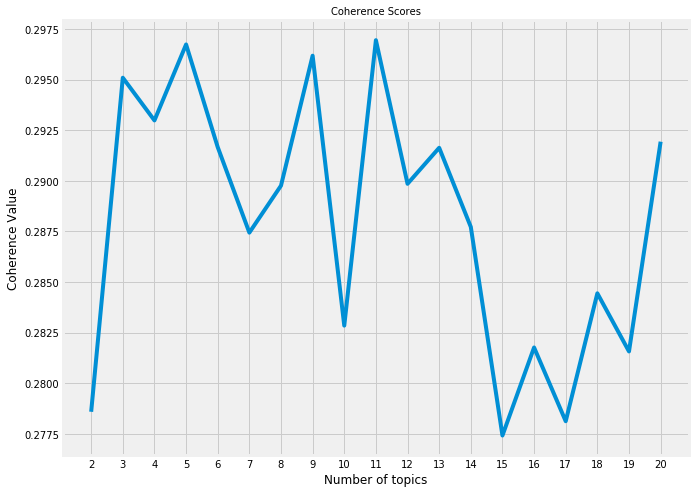

In [9]:
#plot the coherence scores against numer of topics
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.ticker import MaxNLocator

style.use('fivethirtyeight')
%matplotlib inline
x = [int(i) for i in range(min_topics, max_topics)]
ax = plt.figure(figsize=(10,8))
plt.xticks(x)
plt.plot(x, coherence_scores)
plt.xlabel('Number of topics')
plt.ylabel('Coherence Value')
plt.title('Coherence Scores', fontsize=10)

plt.show()

Based on our coherence score visualization, 11 topics is the optimum number but all of these scores are fairly close to one another. Let's try a couple models varying n_topics to see how it separates the text. 

In [5]:
#fit lda model with 11 topics
NUM_TOPICS = 11
ldamodel_final = LdaModel(corpus, 
                    num_topics = NUM_TOPICS, 
                    id2word=dictionary, passes=10,
                   random_state=13) 

In [10]:
ldamodel_final.print_topics(num_words=5)

[(0,
  '0.017*"sour" + 0.015*"tart" + 0.014*"cherri" + 0.013*"like" + 0.013*"sweet"'),
 (1,
  '0.016*"head" + 0.016*"tast" + 0.014*"spice" + 0.013*"flavor" + 0.013*"nice"'),
 (2,
  '0.024*"coffe" + 0.017*"chocol" + 0.015*"dark" + 0.014*"bourbon" + 0.014*"head"'),
 (3,
  '0.041*"hop" + 0.021*"malt" + 0.018*"head" + 0.017*"nice" + 0.015*"tast"'),
 (4,
  '0.028*"hop" + 0.016*"bitter" + 0.015*"ipa" + 0.015*"citru" + 0.014*"head"'),
 (5,
  '0.008*"head" + 0.007*"hop" + 0.007*"tast" + 0.006*"flavor" + 0.005*"malt"'),
 (6,
  '0.021*"sweet" + 0.019*"malt" + 0.016*"caramel" + 0.016*"head" + 0.015*"brown"'),
 (7,
  '0.025*"chocol" + 0.023*"dark" + 0.017*"head" + 0.017*"roast" + 0.016*"malt"'),
 (8,
  '0.023*"light" + 0.021*"tast" + 0.017*"head" + 0.014*"like" + 0.013*"malt"'),
 (9,
  '0.015*"like" + 0.015*"head" + 0.014*"flavor" + 0.013*"tast" + 0.012*"sweet"'),
 (10,
  '0.064*"rye" + 0.019*"hop" + 0.016*"malt" + 0.012*"tast" + 0.010*"flavor"')]

- 0: Sours group
- 1: Spice could mean a few things - heat or spice. And if it refers to spice, it could be a descriptor for Belgian yeast or actual spice addition. 
- 2: Dark ales group, think roasty stouts
- 3: Generic
- 4: IPA group - citrus, ipa, bitter and hop.
- 5: Generic
- 6: Brown ales group, possibly amber ales or any style heavy on caramel malts
- 7: Roasty stouts
- 8: Light could possibly be a light ale or lager category
- 9: Generic
- 10: Rye ales

Again, the model did pretty well. It seems to differentiate between dark and lighter ales pretty well but there are still some questionable groups. Let's try another amount of topics and visualize.

In [42]:
print('Perplexity: ', ldamodel.log_perplexity(corpus))

Perplexity:  -6.811303528442023


In [6]:
#visualize the lda model with 11 topics
import pyLDAvis.gensim
import pickle
import pyLDAvis

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel_final, corpus, dictionary)

MemoryError: 

As we can see above, there are many overlapping and large bubbles in the visualization. This could be a sign of less than optimal topic modelling. Let's try five topics, which was comparable in coherence score. 

In [ ]:
#fit the model with 5 topics
NUM_TOPICS = 5
ldamodel_final2 = LdaModel(corpus, 
                    num_topics = NUM_TOPICS, 
                    id2word=dictionary, passes=10,
                   random_state=13) 

In [9]:
ldamodel_final2.print_topics(num_words=10)

[(0,
  '0.017*"sweet" + 0.013*"head" + 0.013*"tast" + 0.012*"alcohol" + 0.012*"flavor" + 0.012*"like" + 0.012*"fruit" + 0.009*"carbon" + 0.009*"nice" + 0.009*"pour"'),
 (1,
  '0.018*"tast" + 0.017*"light" + 0.016*"head" + 0.013*"flavor" + 0.012*"like" + 0.011*"carbon" + 0.011*"smell" + 0.011*"sweet" + 0.011*"good" + 0.011*"nice"'),
 (2,
  '0.022*"chocol" + 0.020*"dark" + 0.018*"coffe" + 0.016*"head" + 0.014*"malt" + 0.014*"tast" + 0.014*"roast" + 0.013*"flavor" + 0.012*"sweet" + 0.012*"black"'),
 (3,
  '0.034*"hop" + 0.024*"malt" + 0.018*"head" + 0.016*"nice" + 0.016*"tast" + 0.015*"sweet" + 0.012*"caramel" + 0.012*"good" + 0.012*"bitter" + 0.012*"flavor"'),
 (4,
  '0.031*"hop" + 0.016*"bitter" + 0.015*"ipa" + 0.014*"citru" + 0.014*"head" + 0.013*"nice" + 0.013*"malt" + 0.013*"tast" + 0.011*"good" + 0.011*"flavor"')]

- 0: Seasonal or flavored beers
- 1: Light Lagers and ales
- 2: Dark, roasty ales
- 3: Hoppy ales
- 4: IPA's

In [11]:
print('Perplexity: ', ldamodel_final2.log_perplexity(corpus))

Perplexity:  -6.800997492964288


In [ ]:
#visualize the lda model
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel_final2, corpus, dictionary)

Notice the space between the bubbles now. The topics bubbles are fairly large in size and have good separation, meaning our modelling with 5 topics could be favorable over 11 topics. Let's run with this model. 

In [16]:
#create function to pull out desired info from lda model
def format_topics_sentences(ldamodel=ldamodel_final2, corpus=corpus, texts=us_reviews):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel_final2, corpus=corpus, texts=us_reviews)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.6034,"hop, malt, head, nice, tast, sweet, caramel, g...","[favorit, pour, dark, golden, color, head, wai..."
1,1,2.0,0.5519,"chocol, dark, coffe, head, malt, tast, roast, ...","[fan, dark, flavor, al, met, mark, start, crea..."
2,2,1.0,0.6940,"tast, light, head, flavor, like, carbon, smell...","[purpl, virtual, head, second, finger, head, d..."
3,3,0.0,0.6406,"sweet, head, tast, alcohol, flavor, like, frui...","[brown, bottl, cork, cage, batch, bottl, accor..."
4,4,1.0,0.9955,"tast, light, head, flavor, like, carbon, smell...","[american, style, hefe, tast, delici, time, st..."
5,5,3.0,0.5108,"hop, malt, head, nice, tast, sweet, caramel, g...","[balanc, pale, al, market, food, pair, stake, ..."
6,6,2.0,0.7764,"chocol, dark, coffe, head, malt, tast, roast, ...","[pour, nearli, pitch, black, color, dark, choc..."
7,7,2.0,0.9806,"chocol, dark, coffe, head, malt, tast, roast, ...","[nice, size, head, beauti, lace, dark, opaqu, ..."
8,8,1.0,0.4708,"tast, light, head, flavor, like, carbon, smell...","[pour, hazi, brown, orang, medium, white, head..."
9,9,1.0,0.9903,"tast, light, head, flavor, like, carbon, smell...","[tast, appear, pale, hazi, gold, head, quickli..."


In [17]:
df_dominant_topic.shape

(1630, 5)

In [21]:
#concatenate the dominant topic df with the beer_200_text df
beer_lda = pd.concat([df_dominant_topic, beer_200_text], axis=1)

#preview the dataset
beer_lda.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Unnamed: 0,beer_id,brewery_name,beer_name,lemmatized_text
0,0,3.0,0.6034,"hop, malt, head, nice, tast, sweet, caramel, g...","[favorit, pour, dark, golden, color, head, wai...",0,5,Abita Brewing Co.,Amber,becoming favorite mine pours dark golden color...
1,1,2.0,0.5519,"chocol, dark, coffe, head, malt, tast, roast, ...","[fan, dark, flavor, al, met, mark, start, crea...",1,6,Abita Brewing Co.,Turbodog,fan dark flavorful ale met mark well started c...
2,2,1.0,0.6940,"tast, light, head, flavor, like, carbon, smell...","[purpl, virtual, head, second, finger, head, d...",2,7,Abita Brewing Co.,Purple Haze,purple virtually head second finger head dissi...
3,3,0.0,0.6406,"sweet, head, tast, alcohol, flavor, like, frui...","[brown, bottl, cork, cage, batch, bottl, accor...",3,10,Allagash Brewing Company,Dubbel Ale,brown ml bottle corked caged batch bottled acc...
4,4,1.0,0.9955,"tast, light, head, flavor, like, carbon, smell...","[american, style, hefe, tast, delici, time, st...",4,17,Widmer Brothers Brewing Company,Widmer Hefeweizen,american style hefe taste delicious every time...
5,5,3.0,0.5108,"hop, malt, head, nice, tast, sweet, caramel, g...","[balanc, pale, al, market, food, pair, stake, ...",5,39,3 Floyds Brewing Co.,Alpha King,well balanced pale ale market made go food pai...
6,6,2.0,0.7764,"chocol, dark, coffe, head, malt, tast, roast, ...","[pour, nearli, pitch, black, color, dark, choc...",6,54,Redhook Ale Brewery,Redhook Blackhook Porter,pours nearly pitch black color dark chocolatey...
7,7,2.0,0.9806,"chocol, dark, coffe, head, malt, tast, roast, ...","[nice, size, head, beauti, lace, dark, opaqu, ...",7,55,Redhook Ale Brewery,Redhook Double Black Stout,nice sized head really beautiful lacing dark q...
8,8,1.0,0.4708,"tast, light, head, flavor, like, carbon, smell...","[pour, hazi, brown, orang, medium, white, head...",8,58,Allagash Brewing Company,Grand Cru,pours hazy brown orange medium thick white hea...
9,9,1.0,0.9903,"tast, light, head, flavor, like, carbon, smell...","[tast, appear, pale, hazi, gold, head, quickli...",9,59,Allagash Brewing Company,White,tasted appearance pale hazy gold thin head qui...


In [23]:
beer_lda = beer_lda.drop(['Unnamed: 0'], axis=1)

In [24]:
#save the dataset locally
beer_lda.to_csv(r'F:\Datasets\beer_lda.csv')